In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Установка случайного зерна для воспроизводимости
np.random.seed(42)

df = pd.read_csv("ml_dataset_balanced.csv")

# Копия исходного фрейма
df_realistic = df.copy()

# Вводим шум в параметры (±5% случайного отклонения)
for col in ["temperature", "pressure", "humidity", "NaCl", "KCl"]:
    noise = np.random.normal(0, 0.05, size=len(df_realistic))  # 5% отклонение
    df_realistic[col] = df_realistic[col] * (1 + noise)

# Пересчитываем вероятности дефекта с учетом "нереалистичности"
# Простейшее приближение для эффекта на качество:
df_realistic["defect_prob_realistic"] = (
    0.3 * (df_realistic["pressure"] > 1.5).astype(float) +
    0.3 * (df_realistic["humidity"] < 30).astype(float) +
    0.2 * (df_realistic["NaCl"] < 0.3).astype(float) +
    0.2 * (df_realistic["KCl"] > 0.6).astype(float)
)

# Ограничим значения от 0 до 1
df_realistic["defect_prob_realistic"] = df_realistic["defect_prob_realistic"].clip(0, 1)

# Визуализация
plt.figure(figsize=(10, 5))
sns.histplot(df_realistic["defect_prob_realistic"], bins=30, kde=False, color="salmon", edgecolor="black")
plt.title("Распределение реалистичных вероятностей дефекта")
plt.xlabel("defect_prob_realistic")
plt.ylabel("Частота")
plt.grid(True)
plt.tight_layout()
plt.savefig("defect_prob_distribution_realistic.png")
plt.close()

# Сохраняем новый датасет
df_realistic.to_csv("ml_dataset_realistic.csv", index=False)

"/mnt/data/ml_dataset_realistic.csv", "/mnt/data/defect_prob_distribution_realistic.png"


('/mnt/data/ml_dataset_realistic.csv',
 '/mnt/data/defect_prob_distribution_realistic.png')

In [5]:
df = pd.read_csv("ml_dataset_realistic.csv")
y = (df["defect_prob_realistic"] > 0.5).astype(int)
print(y.value_counts())

defect_prob_realistic
0    1499
1       1
Name: count, dtype: int64


In [7]:
import numpy as np
import pandas as pd

# Устанавливаем сид для воспроизводимости
np.random.seed(42)

# Кол-во примеров
n_samples = 2000

# 1. Генерация реалистичных данных
temperature = np.random.normal(loc=32, scale=5, size=n_samples)       # 22–42°C
pressure = np.random.normal(loc=1.15, scale=0.05, size=n_samples)     # 1.0–1.3 атм
humidity = np.random.normal(loc=40, scale=5, size=n_samples)          # 30–50%
NaCl = np.random.normal(loc=0.52, scale=0.03, size=n_samples)         # 0.45–0.6
KCl = np.random.normal(loc=0.25, scale=0.02, size=n_samples)          # 0.20–0.3

# Клипуем значения в пределах допустимых границ
temperature = np.clip(temperature, 22, 42)
pressure = np.clip(pressure, 1.0, 1.3)
humidity = np.clip(humidity, 30, 50)
NaCl = np.clip(NaCl, 0.45, 0.6)
KCl = np.clip(KCl, 0.2, 0.3)

# 2. Добавляем вероятностную модель дефекта
defect_prob = (
    0.3 * (temperature > 38).astype(float) +
    0.3 * (humidity < 35).astype(float) +
    0.2 * (pressure > 1.25).astype(float) +
    0.1 * ((NaCl < 0.48) | (KCl > 0.28)).astype(float) +
    np.random.normal(0, 0.05, n_samples)
)

defect_prob = np.clip(defect_prob, 0, 1)

# Метка брака
is_defect = (defect_prob > 0.5).astype(int)

# Финальный DataFrame
df = pd.DataFrame({
    "temperature": temperature,
    "pressure": pressure,
    "humidity": humidity,
    "NaCl": NaCl,
    "KCl": KCl,
    "defect_prob": defect_prob,
    "is_defect": is_defect
})

# Сохраняем файл
path = "ml_dataset_realistic_v2.csv"
df.to_csv(path, index=False)

import ace_tools as tools; tools.display_dataframe_to_user(name="Realistic Dataset v2", dataframe=df)

path


ModuleNotFoundError: No module named 'ace_tools'

In [9]:
df = pd.read_csv('ml_dataset_realistic_v3.csv')
df['is_defect'].value_counts()

is_defect
0    978
1    300
Name: count, dtype: int64

In [11]:
import pandas as pd
import numpy as np

# Загрузим текущий датасет
df = pd.read_csv("ml_dataset_realistic_v2.csv")

# Кол-во нужных дефектов
desired_defect_count = 300
current_defect_count = df["is_defect"].sum()
additional_defects_needed = desired_defect_count - current_defect_count

# Примерные "опасные" границы — выйдем за пределы нормальных значений
def generate_defect_row():
    return {
        "temperature": np.random.uniform(68, 90),   # слишком высокая
        "pressure": np.random.uniform(0.5, 1.0),     # слишком низкое
        "humidity": np.random.uniform(10, 30),       # слишком сухо
        "NaCl": np.random.uniform(0.05, 0.15),       # очень мало
        "KCl": np.random.uniform(0.01, 0.1),          # почти нет
        "defect_prob": np.random.uniform(0.85, 1.0),
        "is_defect": 1
    }

# Сгенерируем и добавим в основной датасет
new_defects = pd.DataFrame([generate_defect_row() for _ in range(additional_defects_needed)])
df_augmented = pd.concat([df, new_defects], ignore_index=True)

# Перемешаем строки
df_augmented = df_augmented.sample(frac=1, random_state=42).reset_index(drop=True)

# Сохраним обновлённый файл
augmented_path = "ml_dataset_realistic_v3.csv"
df_augmented.to_csv(augmented_path, index=False)

# Вернём количество дефектов
defect_counts = df_augmented['is_defect'].value_counts()
defect_counts


is_defect
0    1960
1     300
Name: count, dtype: int64

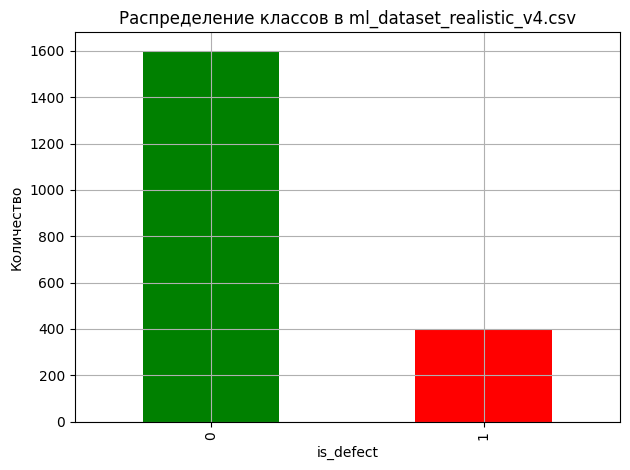

In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# === 1. Кол-во записей
n_samples = 2000
defect_ratio = 0.2
n_defects = int(n_samples * defect_ratio)
n_normals = n_samples - n_defects

# === 2. Функция генерации с шумом
def generate_data(n, defect=False):
    np.random.seed(42 if not defect else 99)
    temperature = np.random.normal(loc=60 if not defect else 80, scale=5 if not defect else 7, size=n)
    pressure = np.random.normal(loc=1.5 if not defect else 2.5, scale=0.2 if not defect else 0.3, size=n)
    humidity = np.random.normal(loc=45 if not defect else 30, scale=5 if not defect else 8, size=n)
    NaCl = np.random.normal(loc=0.5 if not defect else 0.7, scale=0.05, size=n)
    KCl = np.random.normal(loc=0.25 if not defect else 0.4, scale=0.05, size=n)

    data = pd.DataFrame({
        "temperature": temperature,
        "pressure": pressure,
        "humidity": humidity,
        "NaCl": NaCl,
        "KCl": KCl,
        "is_defect": 1 if defect else 0
    })

    return data

# === 3. Генерация нормальных и дефектных данных
normal_data = generate_data(n_normals, defect=False)
defect_data = generate_data(n_defects, defect=True)

# === 4. Объединение и перемешивание
df_realistic_v4 = pd.concat([normal_data, defect_data], ignore_index=True)
df_realistic_v4 = df_realistic_v4.sample(frac=1.0, random_state=42).reset_index(drop=True)

# === 5. Сохранение
df_realistic_v4.to_csv("ml_dataset_realistic_v4.csv", index=False)

# === 6. Быстрый просмотр сбалансированности
df_realistic_v4['is_defect'].value_counts().plot(kind='bar', color=['green', 'red'])
plt.title("Распределение классов в ml_dataset_realistic_v4.csv")
plt.xlabel("is_defect")
plt.ylabel("Количество")
plt.grid(True)
plt.tight_layout()
plt.show()


In [14]:
import pandas as pd
import numpy as np

np.random.seed(42)

# Кол-во примеров
n_samples = 2000
n_defective = n_samples // 2
n_normal = n_samples - n_defective

# ==== Функция генерации одного примера ====
def generate_sample(defective=False):
    # Базовые диапазоны (условно нормальные)
    temp = np.random.normal(loc=50, scale=5)  # Температура
    pressure = np.random.normal(loc=2, scale=0.3)
    humidity = np.random.normal(loc=50, scale=10)
    nacl = np.random.normal(loc=0.5, scale=0.05)
    kcl = np.random.normal(loc=0.25, scale=0.03)

    if defective:
        # Вводим "аномалии"
        if np.random.rand() < 0.5:
            temp += np.random.uniform(20, 40)  # Перегрев
        else:
            temp -= np.random.uniform(20, 30)  # Переохлаждение

        pressure += np.random.choice([-1.5, 1.5]) * np.random.uniform(0.5, 1.5)
        humidity += np.random.choice([-1.0, 1.0]) * np.random.uniform(20, 40)
        nacl += np.random.choice([-0.4, 0.4]) * np.random.uniform(0.1, 0.2)
        kcl += np.random.choice([-0.3, 0.3]) * np.random.uniform(0.1, 0.2)

    return [temp, pressure, humidity, nacl, kcl, int(defective)]

# ==== Генерация всех примеров ====
data = [generate_sample(defective=False) for _ in range(n_normal)] + \
       [generate_sample(defective=True) for _ in range(n_defective)]

columns = ["temperature", "pressure", "humidity", "NaCl", "KCl", "is_defect"]
df = pd.DataFrame(data, columns=columns)

# Перемешиваем
df = df.sample(frac=1.0, random_state=42).reset_index(drop=True)

df.to_csv("balanced_final.csv")


In [ ]:
import torch
import pickle

# === Чтение конфигурации из .pkl файла ===
def load_pkl(file_path):
    print(f"Загрузка .pkl файла: {file_path}")
    with open(file_path, "rb") as f:
        data = pickle.load(f)
    print("Содержимое .pkl файла:")
    print(data)  # Вывод содержимого .pkl файла
    return data

# === Чтение параметров модели из .pt файла ===
def load_pt(file_path):
    print(f"Загрузка .pt файла: {file_path}")
    model_state = torch.load(file_path)
    print("Ключи state_dict модели:")
    for key in model_state.keys():
        print(f"- {key}")  # Список ключей из state_dict
    return model_state

# === Анализ структуры модели SANFIS ===
def analyze_model(model):
    print("Анализ структуры модели SANFIS:")
    print("Доступные атрибуты:")
    print(dir(model))
    print("Обучаемые параметры:")
    for name, param in model.named_parameters():
        print(f"- {name}: {param.shape}")


    # Укажите пути к вашим файлам
    pkl_file = "../sanfis_membfuncs.pkl"
    pt_file = "../sanfis_model.pt"

    # Загрузка и анализ .pkl файла
    membfuncs = load_pkl(pkl_file)

    # Загрузка и анализ .pt файла
    model_state = load_pt(pt_file)

    # Если нужно загрузить модель и проанализировать её структуру
    from sanfis import SANFIS  # Убедитесь, что библиотека SANFIS доступна

    input_dim = len(membfuncs)  # Определяем количество входов из .pkl файла
    model = SANFIS(membfuncs=membfuncs, n_input=input_dim)
    model.load_state_dict(model_state)
    analyze_model(model)


ModuleNotFoundError: No module named 'torch'